In [301]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as ms
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn import ensemble
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [302]:
#Import dataset
cdc3yearswolabor = pd.read_csv('cdc3yearswolabor.csv')
cdc2018 = pd.read_csv('CSV2018.csv')

KeyboardInterrupt: 

In [ ]:
#get rid of 'U' of AB_NICU
cdc3yearswolabor =  cdc3yearswolabor[cdc3yearswolabor['AB_NICU'].isin(['Y', 'N'])]
cdc2018 = cdc2018[cdc2018['AB_NICU'].isin(['Y', 'N'])]

In [ ]:
cdc3yearswolabor.columns

In [167]:
def create_random_column(df):
    '''
    this creates a list of random numbers between 1 and 1000
    of the same lenght as each column in the dataframe, appends
    a column named "RANDOM" to the dataframe
    '''
    import random
    mylist = []
    for i in range(0,df.shape[0]):
        x = random.randint(1,1000)
        mylist.append(x)
    df['RANDOM'] = mylist
    
    return df

In [168]:
cdc3yearswolabor = create_random_column(cdc3yearswolabor)

In [169]:
cdc3yearswolabor.shape

(11611043, 56)

In [129]:
print(cdc3yearswolabor['AB_NICU'].unique())
cdc3yearswolabor['AB_NICU'].value_counts()

['N' 'Y']


N    10572029
Y     1039014
Name: AB_NICU, dtype: int64

In [130]:
print(cdc3yearswolabor.columns)

Index(['Unnamed: 0', 'MAGER9', 'RESTATUS', 'MRACEHISP', 'MAR_P', 'DMAR',
       'MEDUC', 'FAGEREC11', 'FRACEHISP', 'FEDUC', 'PRIORLIVE', 'PRIORDEAD',
       'PRIORTERM', 'LBO_REC', 'TBO_REC', 'ILLB_R11', 'PRECARE5', 'PREVIS_REC',
       'WIC', 'CIG0_R', 'CIG1_R', 'CIG2_R', 'CIG3_R', 'BMI_R', 'WTGAIN_REC',
       'RF_PDIAB', 'RF_GDIAB', 'RF_PHYPE', 'RF_GHYPE', 'RF_EHYPE', 'RF_PPTERM',
       'RF_INFTR', 'RF_FEDRG', 'RF_ARTEC', 'RF_CESAR', 'RF_CESARN', 'IP_GON',
       'IP_SYPH', 'IP_CHLAM', 'IP_HEPB', 'IP_HEPC', 'DPLURAL', 'AB_NICU',
       'CA_ANEN', 'CA_MNSB', 'CA_CCHD', 'CA_CDH', 'CA_OMPH', 'CA_GAST',
       'CA_LIMB', 'CA_CLEFT', 'CA_CLPAL', 'CA_DOWN', 'CA_DISOR', 'CA_HYPO',
       'RANDOM'],
      dtype='object')


In [240]:
cdc3yearswolabor['RF_PDIAB'].value_counts()

N    11498381
Y      104893
U        7769
Name: RF_PDIAB, dtype: int64

In [241]:
cdc3yearswolabor['RF_PHYPE'].value_counts()

N    11383549
Y      219725
U        7769
Name: RF_PHYPE, dtype: int64

In [131]:
# create 2 new datasets 
# 1. mothers that have risk factor diabetes

diabetes_df = cdc3yearswolabor[cdc3yearswolabor['RF_PDIAB'] == 'Y']
print(diabetes_df.shape)

# 2. mothers that have risk factor hypertension
hypertension_df = cdc3yearswolabor[cdc3yearswolabor['RF_PHYPE'] == 'Y']
print(hypertension_df.shape)

(104893, 56)
(219725, 56)


In [134]:
#LabelEncoding Function. Thanks Ira!
def LabelEncoding(dataframe):
    '''
    Function that takes a dataframe and transforms it with label encoding on all the categorical features.
    '''
    
    #create a list using object types since dataframe.dtypes.value_counts() only shows objects and int64
    objlist = list(dataframe.select_dtypes(include=['object']).columns)
    
    #change type then transform column using cat codes
    for col in objlist:
        dataframe[col] = dataframe[col].astype('category')
        dataframe[col] = dataframe[col].cat.codes
    
    return dataframe

In [135]:
diabetes_df = LabelEncoding(diabetes_df)
hypertension_df = LabelEncoding(hypertension_df)

In [296]:
# function to split out holdout test set
def split_sets(dataframe, seed, test_prop=0.1): 
    '''
    - A function that splits specifically a dataframe into a train and test portion
    - Requires multiple assignment: train, test
    ---------------
    - dataframe: dataframe to be split
    - seed: set seed for reproducability
    - test_prop: takes a float - proportion of dataframe that should be allocated to the test set
    '''

    np.random.seed(seed)
    testIdxes = np.random.choice(range(0,dataframe.shape[0]), size=round(dataframe.shape[0]*test_prop), replace=False)
    trainIdxes = list(set(range(0,dataframe.shape[0])) - set(testIdxes))

    train = dataframe.iloc[trainIdxes,:]
    test  = dataframe.iloc[testIdxes,:]
    
    return train, test

In [297]:
train_dia, test_dia = split_sets(diabetes_df, 0, test_prop=0.1)
train_hyper, test_hyper = split_sets(hypertension_df, 0, test_prop=0.9)

In [298]:
print(train_dia.shape)
print(test_dia.shape)

print(train_hyper.shape)
print(test_hyper.shape)

(94404, 56)
(10489, 56)
(21973, 56)
(197752, 56)


In [299]:
train_hyper.columns

Index(['Unnamed: 0', 'MAGER9', 'RESTATUS', 'MRACEHISP', 'MAR_P', 'DMAR',
       'MEDUC', 'FAGEREC11', 'FRACEHISP', 'FEDUC', 'PRIORLIVE', 'PRIORDEAD',
       'PRIORTERM', 'LBO_REC', 'TBO_REC', 'ILLB_R11', 'PRECARE5', 'PREVIS_REC',
       'WIC', 'CIG0_R', 'CIG1_R', 'CIG2_R', 'CIG3_R', 'BMI_R', 'WTGAIN_REC',
       'RF_PDIAB', 'RF_GDIAB', 'RF_PHYPE', 'RF_GHYPE', 'RF_EHYPE', 'RF_PPTERM',
       'RF_INFTR', 'RF_FEDRG', 'RF_ARTEC', 'RF_CESAR', 'RF_CESARN', 'IP_GON',
       'IP_SYPH', 'IP_CHLAM', 'IP_HEPB', 'IP_HEPC', 'DPLURAL', 'AB_NICU',
       'CA_ANEN', 'CA_MNSB', 'CA_CCHD', 'CA_CDH', 'CA_OMPH', 'CA_GAST',
       'CA_LIMB', 'CA_CLEFT', 'CA_CLPAL', 'CA_DOWN', 'CA_DISOR', 'CA_HYPO',
       'RANDOM'],
      dtype='object')

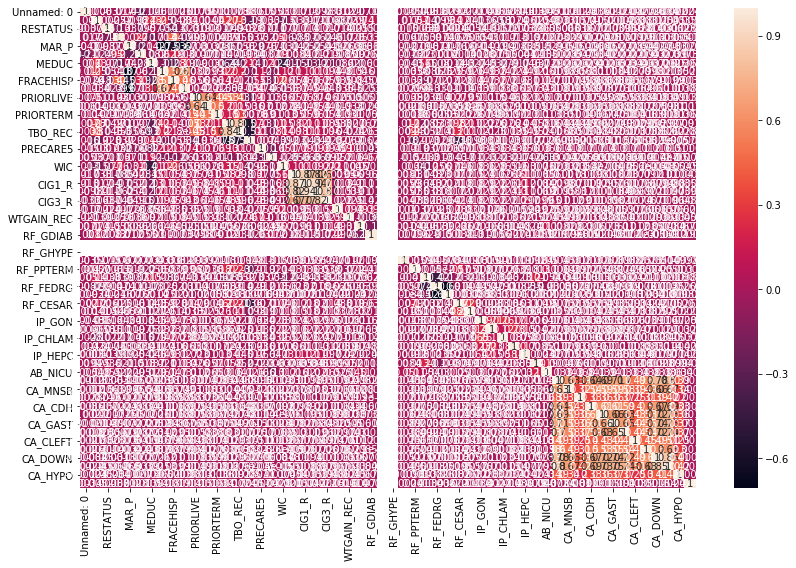

In [231]:
cor = train_hyper.corr()
plt.figure(figsize=(12,8))
sns.heatmap(cor,annot=True)
plt.tight_layout()

In [140]:
X_train_dia = train_dia.drop('AB_NICU', axis=1)
y_train_dia = train_dia['AB_NICU']
X_test_dia = test_dia.drop('AB_NICU', axis=1)
y_test_dia = test_dia['AB_NICU']

In [300]:
X_train_hyper = train_hyper.drop('AB_NICU', axis=1)
y_train_hyper = train_hyper['AB_NICU']
X_test_hyper = test_hyper.drop('AB_NICU', axis=1)
y_test_hyper = test_hyper['AB_NICU']
y_train_hyper.value_counts()

0    17347
1     4626
Name: AB_NICU, dtype: int64

In [42]:
#Downsampled
#dsample_dia = downsample_df(train_dia)
#dsample_hyper = downsample_df(train_hyper)

In [142]:
print(X_train_dia.shape)
print(X_test_dia.shape)
print(y_train_dia.shape)
print(y_test_dia.shape)

(94404, 55)
(10489, 55)
(94404,)
(10489,)


In [233]:
print(X_train_hyper.shape)
print(X_test_hyper.shape)
print(y_train_hyper.shape)
print(y_test_hyper.shape)

(197753, 55)
(21972, 55)
(197753,)
(21972,)


In [ ]:
#sample_weight=sample_weights_data
#scale_pos_weight

In [234]:
#XGBoost initial fit 
xgb = XGBClassifier()
xgb.set_params(random_state=0)
xgb.fit(X_train_hyper, y_train_hyper)
print("The training error is: %.5f" % (1 - xgb.score(X_train_hyper, y_train_hyper)))
print("The test error is: %.5f" % (1 - xgb.score(X_train_hyper, y_train_hyper)))

The training error is: 0.19782
The test error is: 0.19782


In [235]:
cm_test = confusion_matrix(y_test_hyper, xgb.predict(X_test_hyper))
cm_test

array([[16939,   342],
       [ 3982,   709]])

In [239]:
xgb_1 = XGBClassifier()
xgb_1.set_params(random_state=0, class_weights = 'balanced')
xgb_1.fit(X_train_hyper, y_train_hyper)
print("The training error is: %.5f" % (1 - xgb_1.score(X_train_hyper, y_train_hyper)))
print("The test error is: %.5f" % (1 - xgb_1.score(X_test_hyper, y_test_hyper)))

The training error is: 0.19782
The test error is: 0.19680


In [238]:
cm_test_1 = confusion_matrix(y_test_hyper, xgb_1.predict(X_test_hyper))
cm_test_1

array([[16939,   342],
       [ 3982,   709]])

In [242]:
xgb_2 = XGBClassifier()
xgb_2.set_params(random_state=0, scale_pos_weight = 4)
xgb_2.fit(X_train_hyper, y_train_hyper)
print("The training error is: %.5f" % (1 - xgb_2.score(X_train_hyper, y_train_hyper)))
print("The test error is: %.5f" % (1 - xgb_2.score(X_test_hyper, y_test_hyper)))

The training error is: 0.31256
The test error is: 0.31222


In [243]:
cm_test_2 = confusion_matrix(y_test_hyper, xgb_2.predict(X_test_hyper))
cm_test_2

array([[12015,  5266],
       [ 1594,  3097]])

The training error is: 0.37916
The test error is: 0.37871


array([[10168,  7113],
       [ 1208,  3483]])

In [ ]:
#import pickle
# save model to file
# pickle.dump(xgb_1, open("2016beforelabor_downsampled.pickle.dat", "wb"))
# load model later
# loaded_model = pickle.load(open("2016beforelabor_downsampled.pickle.dat", "rb"))

In [249]:
# set the parameter grid
xgb_param_grid ={'learning_rate': [0.001, 0.01, 0.05],
                 'max_depth': [4,5,6],
                 'min_child_weight': [4,5,6],
                 'n_estimators': [200, 300, 400, 500]}

scoring = {'acc': 'accuracy',
           'prec': 'precision',
           'f1': 'f1',
           're':'recall',
           'auc': 'roc_auc'
          }

#grid search
grid_search_xgb_2 = GridSearchCV(xgb_2, xgb_param_grid, scoring=scoring, cv= 3, n_jobs=-1, return_train_score = True, refit = False)
%time grid_search_xgb_2.fit(X_train_hyper, y_train_hyper)

KeyboardInterrupt: 

In [229]:
# save xgb model
#grid_search_xgb.save_model('downsampled_2016_accuracy.model')

In [ ]:
# set the parameter grid
xgb_param_grid ={'learning_rate': [0.001, 0.01, 0.05],
                 'max_depth': [4,5,6],
                 'min_child_weight': [4,5,6],
                 'n_estimators': [200, 300, 400, 500]}

from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)


#grid search
grid_search_xgb_3 = GridSearchCV(xgb_2, xgb_param_grid, scoring='precision', cv= kfold, n_jobs=-1, return_train_score = True)
%time grid_search_xgb_3.fit(X_train_hyper, y_train_hyper)

In [226]:
# get the best parameters
print(grid_search_xgb_2.best_params_)
print(grid_search_xgb_2.best_score_)

{'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300}
0.5744468026230455


In [227]:
confusion_matrix(y_test_hyper, grid_search_xgb_2.best_estimator_.predict(X_test_hyper))

array([[11963,  5318],
       [ 1617,  3074]])

In [171]:
# get the best parameters
print(grid_search_xgb.best_params_)
print(grid_search_xgb.best_score_)

{'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 300}
0.6524887459081221


In [181]:
# get the training/test errors
print("The training error is: %.5f" % (1 - grid_search_xgb.best_estimator_.score(X_train_dia, y_train_dia)))
print("The test error is: %.5f" % (1 - grid_search_xgb.best_estimator_.score(X_test_dia, y_test_dia)))

The training error is: 0.26899
The test error is: 0.26361


In [184]:
confusion_matrix(y_test_dia, grid_search_xgb.best_estimator_.predict(X_test_dia))

array([[7395,  172],
       [2593,  329]])

In [210]:
# change cut of for probabilities 
test_dia_predprob = grid_search_xgb.predict_proba(X_test_dia)[:,1] # should be the 1st
test_dia_predprob[test_dia_predprob>=0.4]=1 
test_dia_predprob[test_dia_predprob<0.4]=0 

#test_dia_predprob = grid_search_xgb.predict_proba(X_test.dia)[:,1]

In [211]:
# create new confusion matrix

confusion_matrix(y_test_dia, test_dia_predprob)

array([[6856,  711],
       [2105,  817]])

In [186]:
# set the parameter grid
xgb_param_grid_2 ={'learning_rate': [0.01, 0.05],
                 'max_depth': [4,5,6],
                 'min_child_weight': [4,5],
                 'n_estimators': [200, 300, 400]}

#grid search
grid_search_xgb_2 = GridSearchCV(xgb_1, xgb_param_grid_2, scoring='precision', cv= 3, n_jobs=-1, return_train_score = True)
%time grid_search_xgb_2.fit(X_train_hyper, y_train_hyper)

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 1min 19s, sys: 984 ms, total: 1min 20s
Wall time: 38min 26s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     class_weights='balanced',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05], 'max_depth': [4, 5, 6],
                         '

In [204]:
# get the training/test errors
print("The training error is: %.5f" % (1 - grid_search_xgb_2.best_estimator_.score(X_train_hyper, y_train_hyper)))
print("The test error is: %.5f" % (1 - grid_search_xgb_2.best_estimator_.score(X_test_hyper, y_test_hyper)))

The training error is: 0.20321
The test error is: 0.20262


In [206]:
#Prediction with tuned hyperparameters
grid_xgb_pred = grid_search_xgb.predict(X_test_hyper)
grid_xgb_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [207]:
confusion_matrix(y_test_hyper, grid_xgb_pred)

array([[17108,   173],
       [ 4318,   373]])

In [26]:
# Get numerical feature importances
importances_xgb = list(xgb.feature_importances_)

# List of tuples with variable and importance
feature_importances_xgb = [(feature, round(importance, 5)) for feature, importance in zip(X_train.columns, importances_xgb)]

# Sort the feature importances by most important first
xgb_feature_importances = sorted(feature_importances_xgb, key = lambda x: x[1], reverse = True )

# Print out the feature and importances 
[print('Variable: {:10} Importance: {}'.format(*pair)) for pair in xgb_feature_importances]

Variable: DPLURAL    Importance: 0.17089000344276428
Variable: RF_PPTERM  Importance: 0.08495999872684479
Variable: RF_GHYPE   Importance: 0.07722999900579453
Variable: RF_PHYPE   Importance: 0.06333000212907791
Variable: ILLB_R11   Importance: 0.05851000174880028
Variable: PREVIS_REC Importance: 0.0480399988591671
Variable: RF_PDIAB   Importance: 0.04075000062584877
Variable: CA_CCHD    Importance: 0.03805999830365181
Variable: RF_GDIAB   Importance: 0.03613999858498573
Variable: PRIORLIVE  Importance: 0.029740000143647194
Variable: FAGEREC11  Importance: 0.025359999388456345
Variable: RF_CESAR   Importance: 0.025210000574588776
Variable: PRECARE5   Importance: 0.024709999561309814
Variable: IP_HEPC    Importance: 0.020430000498890877
Variable: RF_EHYPE   Importance: 0.020010000094771385
Variable: PRIORTERM  Importance: 0.019020000472664833
Variable: CA_GAST    Importance: 0.016100000590085983
Variable: WTGAIN_REC Importance: 0.015209999866783619
Variable: CIG2_R     Importance: 0.013

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [27]:
xgb_feature_importances_top20 = xgb_feature_importances[:20]
featureNames, featureScores = zip(*list(xgb_feature_importances_top20))
xgb_feature_importances_top20

[('DPLURAL', 0.17089),
 ('RF_PPTERM', 0.08496),
 ('RF_GHYPE', 0.07723),
 ('RF_PHYPE', 0.06333),
 ('ILLB_R11', 0.05851),
 ('PREVIS_REC', 0.04804),
 ('RF_PDIAB', 0.04075),
 ('CA_CCHD', 0.03806),
 ('RF_GDIAB', 0.03614),
 ('PRIORLIVE', 0.02974),
 ('FAGEREC11', 0.02536),
 ('RF_CESAR', 0.02521),
 ('PRECARE5', 0.02471),
 ('IP_HEPC', 0.02043),
 ('RF_EHYPE', 0.02001),
 ('PRIORTERM', 0.01902),
 ('CA_GAST', 0.0161),
 ('WTGAIN_REC', 0.01521),
 ('CIG2_R', 0.01352),
 ('CA_MNSB', 0.01348)]

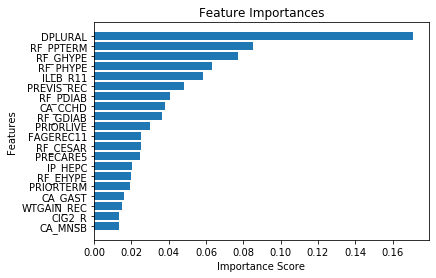

In [28]:
plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
plt.gca().invert_yaxis()
plt.title('feature importance')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importances')
plt.savefig('xgbFI.png')

In [29]:
xgb_params_tuned_model = grid_search_xgb.best_estimator_
xgb_feature_importance = 100.0 * (xgb_params_tuned_model.feature_importances_ / xgb_params_tuned_model.feature_importances_.max())
xgb_important_features = X_train.columns[xgb_feature_importance >= 2]
xgb_unimportant_features = X_train.columns[xgb_feature_importance < 2]

In [30]:
xgb_important_features

Index(['MAGER9', 'RESTATUS', 'MRACEHISP', 'DMAR', 'FAGEREC11', 'PRIORLIVE',
       'PRIORTERM', 'ILLB_R11', 'PRECARE5', 'PREVIS_REC', 'CIG1_R', 'CIG2_R',
       'BMI_R', 'WTGAIN_REC', 'RF_PDIAB', 'RF_GDIAB', 'RF_PHYPE', 'RF_GHYPE',
       'RF_EHYPE', 'RF_PPTERM', 'RF_INFTR', 'RF_CESAR', 'IP_SYPH', 'IP_HEPC',
       'DPLURAL', 'CA_ANEN', 'CA_MNSB', 'CA_CCHD', 'CA_CDH', 'CA_OMPH',
       'CA_GAST', 'CA_LIMB', 'CA_CLEFT', 'CA_CLPAL', 'CA_DOWN', 'CA_DISOR',
       'CA_HYPO'],
      dtype='object')

In [33]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, grid_search_xgb.best_estimator_.predict(X_train))
cm

array([[241549,  69100],
       [126457, 184192]])

In [34]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, grid_search_xgb.best_estimator_.predict(X_test))
cm

array([[279408,  81339],
       [ 14121,  20300]])

In [51]:
# set the parameter grid
xgb_param_grid_3 ={'learning_rate': [0.05],
                 'max_depth': [5],
                 'min_child_weight': [4],
                 'n_estimators': [300]}

scoring = {'acc': 'accuracy',
           'prec': 'precision',
           'f1': 'f1',
           're':'recall',
           'auc': 'roc_auc'
          }

#grid search
grid_search_xgb_3 = GridSearchCV(xgb_1, xgb_param_grid_3, scoring=scoring, cv= 3, n_jobs=-1, return_train_score = True, refit=False)
%time grid_search_xgb_3.fit(X_train, y_train)

CPU times: user 1.14 s, sys: 339 ms, total: 1.48 s
Wall time: 5min 47s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.05], 'max_depth': [5],
                         'min_child_weight': [4], 'n_estimators': [300]},
             pre_dispatch='

In [59]:
grid_search_xgb_3.cv_results_

{'mean_fit_time': array([308.6918776]),
 'std_fit_time': array([0.5117093]),
 'mean_score_time': array([11.73221962]),
 'std_score_time': array([0.11089527]),
 'param_learning_rate': masked_array(data=[0.05],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[5],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[4],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[300],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.05,
   'max_depth': 5,
   'min_child_weight': 4,
   'n_estimators': 300}],
 'split0_test_acc': array([0.66203766]),
 'split1_test_acc': array([0.68220183]),
 'split2_test_acc': array([0.67956233]),
 'mean_test_acc': array([0.67460059]),
 'std_test_acc': array([0.00894847]),
 'rank_test_acc': array

In [72]:
#grid search
grid_search_xgb_4 = GridSearchCV(xgb_1, xgb_param_grid_3, scoring='roc_auc', cv= 5, n_jobs=-1, return_train_score = True)
%time grid_search_xgb_4.fit(X_train, y_train)

CPU times: user 7min 7s, sys: 1.06 s, total: 7min 8s
Wall time: 14min 44s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.05], 'max_depth': [5],
                         'min_child_weight': [4], 'n_estimators': [300]},
             pre_dispatch='

In [73]:
print(grid_search_xgb_4.best_score_)
print(grid_search_xgb_4.best_params_)

0.7355738054596827
{'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300}


In [78]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(y_train, grid_search_xgb_4.best_estimator_.predict(X_train)) 
print(cm_train)

[[241500  69149]
 [126429 184220]]


In [77]:
cm_test = confusion_matrix(y_test, grid_search_xgb_4.best_estimator_.predict(X_test))
print(cm_test)

[[279423  81324]
 [ 14134  20287]]


In [80]:
grid_search_xgb_5 = GridSearchCV(xgb_1, xgb_param_grid_3, scoring='f1', cv= 5, n_jobs=-1, return_train_score = True)
%time grid_search_xgb_5.fit(X_train, y_train)

CPU times: user 7min 23s, sys: 2.01 s, total: 7min 25s
Wall time: 14min 55s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.05], 'max_depth': [5],
                         'min_child_weight': [4], 'n_estimators': [300]},
             pre_dispatch='

In [81]:
cm_test = confusion_matrix(y_test, grid_search_xgb_5.best_estimator_.predict(X_test))
print(cm_test)

[[279423  81324]
 [ 14134  20287]]


In [82]:
grid_search_xgb_6 = GridSearchCV(xgb_1, xgb_param_grid_3, scoring='precision', cv= 5, n_jobs=-1, return_train_score = True)
%time grid_search_xgb_6.fit(X_train, y_train)

CPU times: user 7min 23s, sys: 1.69 s, total: 7min 25s
Wall time: 15min 16s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.05], 'max_depth': [5],
                         'min_child_weight': [4], 'n_estimators': [300]},
             pre_dispatch='

In [84]:
%time grid_search_xgb_6.fit(X_train, y_train)

CPU times: user 7min 10s, sys: 1.25 s, total: 7min 11s
Wall time: 14min 32s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.05], 'max_depth': [5],
                         'min_child_weight': [4], 'n_estimators': [300]},
             pre_dispatch='

In [86]:
cm_test = confusion_matrix(y_test, grid_search_xgb_6.best_estimator_.predict(X_test))
print(cm_test)

[[279423  81324]
 [ 14134  20287]]


In [87]:
grid_search_xgb_7 = GridSearchCV(xgb_1, xgb_param_grid_3, scoring='f1_weighted', cv= 5, n_jobs=-1, return_train_score = True)
%time grid_search_xgb_7.fit(X_train, y_train)

CPU times: user 7min 6s, sys: 1.2 s, total: 7min 7s
Wall time: 14min 30s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.05], 'max_depth': [5],
                         'min_child_weight': [4], 'n_estimators': [300]},
             pre_dispatch='

In [88]:
cm_test = confusion_matrix(y_test, grid_search_xgb_7.best_estimator_.predict(X_test))
cm_test

array([[279423,  81324],
       [ 14134,  20287]])

In [259]:
# hypertension_df
# reduce feature space 
feature_list = ['MAGER9', 'CIG1_R', 'CIG3_R', 'MRACEHISP', 'MEDUC', 'FAGEREC11', 'FRACEHISP', 'FEDUC', 'PRIORLIVE', 'PRIORDEAD', 'AB_NICU']

In [263]:
# train contains 10% of all data
reduced_feature_hyp = hypertension_df[feature_list]
train_red_feat_hyp, test_red_feat_hyp = split_sets(reduced_feature_hyp, 0, test_prop=0.9)

In [265]:
# select x and y
X_train_red_hyper = train_red_feat_hyp.drop('AB_NICU', axis=1)
y_train_red_hyper = train_red_feat_hyp['AB_NICU']

X_test_red_hyper = test_red_feat_hyp.drop('AB_NICU', axis=1)
y_test_red_hyper = test_red_feat_hyp['AB_NICU']

In [279]:
xgb_red = XGBClassifier()
xgb_red.set_params(random_state=0, scale_pos_weight = 4) # , scale_pos_weight = 4
xgb_red.fit(X_train_red_hyper, y_train_red_hyper)
print("The training error is: %.5f" % (1 - xgb_red.score(X_train_red_hyper, y_train_red_hyper)))
print("The test error is: %.5f" % (1 - xgb_red.score(X_test_red_hyper, y_test_red_hyper)))

The training error is: 0.44810
The test error is: 0.46431


In [280]:
confusion_matrix(y_test_red_hyper, xgb_red.predict(X_test_red_hyper))

array([[80920, 74324],
       [17494, 25014]])

In [288]:
xgb_param_grid_2 ={'learning_rate': [0.01, 0.05],
                 'max_depth': [4,5,6,7],
                 'min_child_weight': [3,4,5],
                 'n_estimators': [200, 300, 400, 500]}

#scoring = {'acc': 'accuracy',
#           'prec': 'precision',
#           'f1': 'f1',
#           're':'recall',
#          'auc': 'roc_auc'
#          }

#grid search
grid_search_xgb_3 = GridSearchCV(xgb_red, xgb_param_grid_2, scoring='precision', cv= 5, n_jobs=-1, return_train_score = True)
%time grid_search_xgb_3.fit(X_train_red_hyper, y_train_red_hyper)

CPU times: user 4.94 s, sys: 607 ms, total: 5.55 s
Wall time: 6min 40s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=4, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05],
                         'max_depth': [4, 5, 6, 7],
                         'min_child_weight': [3, 4, 5],
     

In [289]:
print(grid_search_xgb_3.best_score_)
print(grid_search_xgb_3.best_params_)

0.24939437102935236
{'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200}


In [290]:
confusion_matrix(y_test_red_hyper, grid_search_xgb_3.best_estimator_.predict(X_test_red_hyper))

array([[78989, 76255],
       [17224, 25284]])

In [291]:
xgb_param_grid_2 ={'learning_rate': [0.01, 0.05],
                 'max_depth': [4,5,6,7],
                 'min_child_weight': [3,4,5],
                 'n_estimators': [200, 300, 400, 500]}

#scoring = {'acc': 'accuracy',
#           'prec': 'precision',
#           'f1': 'f1',
#           're':'recall',
#          'auc': 'roc_auc'
#          }

#grid search
grid_search_xgb_4 = GridSearchCV(xgb_red, xgb_param_grid_2, scoring='recall', cv= 5, n_jobs=-1, return_train_score = True)
%time grid_search_xgb_4.fit(X_train_red_hyper, y_train_red_hyper)

CPU times: user 4.71 s, sys: 594 ms, total: 5.31 s
Wall time: 6min 50s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=4, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05],
                         'max_depth': [4, 5, 6, 7],
                         'min_child_weight': [3, 4, 5],
     

In [292]:
print(grid_search_xgb_4.best_score_)
print(grid_search_xgb_4.best_params_)

0.6134840131792015
{'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 200}


In [293]:
confusion_matrix(y_test_red_hyper, grid_search_xgb_4.best_estimator_.predict(X_test_red_hyper))

array([[79535, 75709],
       [17368, 25140]])

In [295]:
importances_xgb_red = list(xgb_red.feature_importances_)
importances_grid_xgb = list(grid_search_xgb_4.feature_importances_)

# List of tuples with variable and importance
feature_importances_xgb_red = [(feature, round(importance, 5)) for feature, importance in zip(X_train.columns, importances_xgb_red)]


AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'